# A1 Data Curation

The goal of this notebook is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2020.

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import matplotlib.ticker as mtick

## Step 1: Gathering the data

In [2]:
def api_call(endpoint, endpoint_type ,access_type, first_month, last_month):
    
    #create parameter dictionary 
    parameters = {"project" : "en.wikipedia.org",
                 "granularity" : "monthly",
                 "start" : first_month,
                # for end use 1st day of month following final month of data
                 "end" : last_month
                    }
    if endpoint_type == "pageviews":
        parameters['agent'] = 'user' # filter only available for pageviews endpoint
        parameters["access"]= access_type
    else:
        parameters["access-site"]= access_type
    
    call = requests.get(endpoint.format(**parameters))
    response = call.json()
    #save to a json file in the required format 'apiname_accesstype_firstmonth-lastmonth.json'
    with open(f'{endpoint_type}_{access_type}_{first_month[0:6]}_{last_month[0:6]}.json', 'w') as f:
        json.dump(response['items'], f)
    

### Get data for legacy pagecounts endpoint and save as json

In [3]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

access_type = ["desktop-site","mobile-site"] #possible options for pagecounts api endpoint access types
start_legacy = "2008010100" #date for start in YYYYMMDDHH format
end_legacy = "2016080100"

for i in access_type: #creates a json file for each access type
    api_call(endpoint_legacy, "pagecounts" ,i, start_legacy, end_legacy)


### Get data for pageviews endpoint and save as json for each access type


In [4]:
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

access_type = ["desktop","mobile-app", "mobile-web"] #possible options for pageviews api endpoint access types
start_pageviews = "2015070100"
end_pageviews = "2020090100"

for i in access_type:
    api_call(endpoint_pageviews, "pageviews" ,i, start_pageviews, end_pageviews)


## Step 2: Processing the data

### Combine pageviews mobile app and mobile web

In [5]:
#read from mobile app and web json files for pageviews
web_df = pd.read_json(f'pageviews_mobile-web_{start_pageviews[0:6]}_{end_pageviews[0:6]}.json',convert_dates=False)
app_df = pd.read_json(f'pageviews_mobile-app_{start_pageviews[0:6]}_{end_pageviews[0:6]}.json',convert_dates=False)

#merge on columns
pageview_mobile_df = web_df.merge(app_df, on =['project','agent','granularity','timestamp'])
#combine views from app and web for mobile
pageview_mobile_df['views'] = pageview_mobile_df['views_x']+pageview_mobile_df['views_y'] 

### Read all data and seperate retrieve year and month from timestamp

In [6]:
#read pagecount desktop and mobile data from json files
pagecount_desktop_df = pd.read_json(f'pagecounts_desktop-site_{start_legacy[0:6]}_{end_legacy[0:6]}.json',convert_dates=False)
pagecount_mobile_df = pd.read_json(f'pagecounts_mobile-site_{start_legacy[0:6]}_{end_legacy[0:6]}.json',convert_dates=False)
#rename count to views for consistency across dataframes
pagecount_desktop_df = pagecount_desktop_df.rename(columns={"count": "views"})
pagecount_mobile_df = pagecount_mobile_df.rename(columns={"count": "views"})

#read from desktop json files for pageviews
pageview_desktop_df = pd.read_json(f'pageviews_desktop_{start_pageviews[0:6]}_{end_pageviews[0:6]}.json',convert_dates=False)

Function to retrieve only the required columns from a dataframe

In [7]:
def get_required_cols(df):
    df['year'] = pd.DatetimeIndex(pd.to_datetime(df['timestamp'],format='%Y%m%d%H')).year
    df['month'] = pd.DatetimeIndex(pd.to_datetime(df['timestamp'],format='%Y%m%d%H')).month
    
    return df[['year','month','views']]

Get dataframes with required columns for mobile and desktop dataframes of each api endpoint

In [8]:
pageview_mobile = get_required_cols(pageview_mobile_df)
pagecount_mobile = get_required_cols(pagecount_mobile_df)
pagecount_desktop = get_required_cols(pagecount_desktop_df)
pageview_desktop = get_required_cols(pageview_desktop_df)

### Combine all the data into a single dataframe

In [9]:
#merge pagecount mobile and desktop
total_df = pagecount_desktop.merge(pagecount_mobile,how='outer',on=['year','month'])
total_df = total_df.rename(columns={"views_x": "pagecount_desktop_views","views_y": "pagecount_mobile_views"})
##merge with pageview mobile
total_df = total_df.merge(pageview_mobile,how='outer',on=['year','month'])
total_df = total_df.rename(columns={"views": "pageview_mobile_views"})
##merge with pageview desktop
total_df = total_df.merge(pageview_desktop,how='outer',on=['year','month'])
total_df = total_df.rename(columns={"views": "pageview_desktop_views"})

##replace NaNs with 0
total_df = total_df.fillna(0)

##add new columns for total count
total_df['pagecount_all_views'] = total_df['pagecount_desktop_views'] + total_df['pagecount_mobile_views']
total_df['pageview_all_views'] = total_df['pageview_desktop_views'] + total_df['pageview_mobile_views']

### Save to csv

In [10]:
total_df.to_csv("en-wikipedia_traffic_200712-202008.csv",index=False)

## Step 3: Analyze the data

In [11]:
df = pd.read_csv("en-wikipedia_traffic_200712-202008.csv")
##combine year month for date column for plot
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(Day=1))

### Update ticker class to specify custom exponents for y axis in plot

In [40]:
class OOMFormatter(mtick.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        mtick.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

### Plot page views vs time

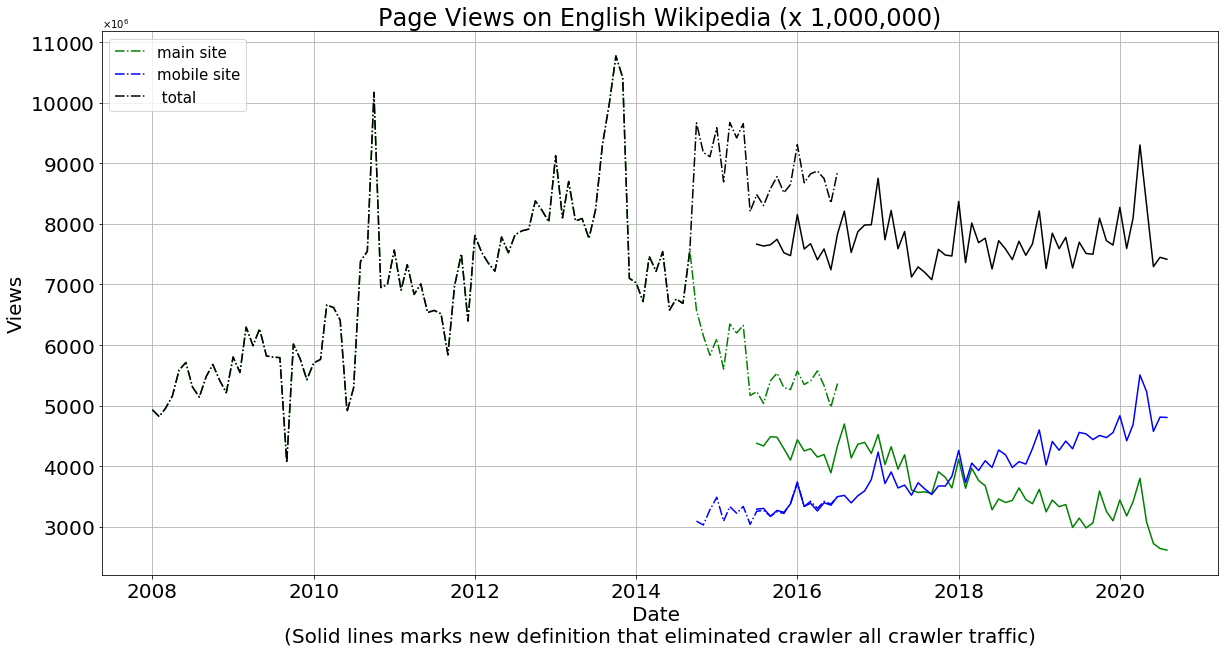

In [47]:
fig = plt.figure(figsize=(20,10))

df = df.replace(0, np.nan) #prevent plotting a line when value is 0
#plot all the required time series
plt.plot(df['Date'],df['pagecount_desktop_views'],color='green',linestyle='-.',label='main site')
plt.plot(df['Date'],df['pagecount_mobile_views'],color='blue',linestyle='-.',label='mobile site')
plt.plot(df['Date'],df['pagecount_all_views'],color='black', linestyle='-.',label =' total')
plt.plot(df['Date'],df['pageview_desktop_views'],color='green')
plt.plot(df['Date'],df['pageview_mobile_views'],color='blue')
plt.plot(df['Date'],df['pageview_all_views'],color='black')

#Change scientific format for y axis exponents
plt.gcf().axes[0].yaxis.set_major_formatter(OOMFormatter(6, "%1.0f"))
plt.gcf().axes[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))

#increase tick size
plt.gcf().axes[0].tick_params(axis='both', which='major', labelsize=20)

##add legend and axis labels
plt.legend(loc=2,prop={'size': 15})
plt.xlabel('Date \n(Solid lines marks new definition that eliminated crawler all crawler traffic)',fontdict = {'fontsize' : 20})
plt.ylabel('Views',fontdict = {'fontsize' : 20})
plt.title('Page Views on English Wikipedia (x 1,000,000)',fontdict = {'fontsize' : 24})

plt.grid() #add gridlines 
plt.show()

### Save plot as png

In [48]:
fig.savefig('wikipedia_views.png')